# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an dataframe into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
data_home = os.path.join('data')

In [3]:
os.listdir(data_home)

['.DS_Store',
 'c3w2_Quiz-2.jpeg',
 'amazon_baby_subset.csv',
 'amazon_baby_subset.sframe',
 'module-4-assignment-validation-idx.json',
 'important_words.json',
 'module-4-assignment-train-idx.json']

## Load and process review dataset
**1**. For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews. 

Load the dataset into a data frame named `products`.

In [4]:
products = pd.read_csv(os.path.join(data_home, 'amazon_baby_subset.csv'))

products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


**2**. Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

* Remove punctuation
* Compute word counts (only for the **important_words**)

We start with the first item as follows:

* If your tool supports it, fill n/a values in the review column with empty strings. The n/a values indicate empty reviews. For instance, Pandas's the fillna() method lets you replace all N/A's in the review columns as follows:

In [5]:
products = products.fillna({'review':''}) # fill in N/A's in the review column

In [6]:
import json
with open(os.path.join(data_home, 'important_words.json'), 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

* Write a function **remove_punctuation** that takes a line of text and removes all punctuation from that text. The function should be analogous to the following Python code:

In [7]:
import re
import string

def remove_punctuation(text):
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

* Apply the **remove_punctuation** function on every element of the **review** column and assign the result to the new column **review_clean**.

In [8]:
# remove punctuation
products['review_clean'] = products['review'].apply(remove_punctuation)

**3**. Now we proceed with the second item. For each word in **important_words**, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in **important_words** which keeps a count of the number of times the respective word occurs in the review text.

**Note**: There are several ways of doing this. One way is to create an anonymous function that counts the occurrence of a particular word and apply it to every element in the **review_clean** column. Repeat this step for every word in **important_words**. Your code should be analogous to the following:

In [9]:
# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda x: x.split().count(word))

**4**. After #2 and #3, the data frame **products** should contain one column for each of the 193 **important_words**. As an example, the column **perfect** contains a count of the number of times the word **prefect** occurs in each of the reviews.

In [10]:
products.head()

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train-Validation split

**5**. We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.  

In [14]:
# from sklearn.model_selection import train_test_split

# train_data, validation_data = train_test_split(products, test_size=0.8, random_state=2)

If you are not using SFrame, download the list of indices for the training and validation sets:

* module-4-assignment-train-idx.json
* module-4-assignment-validation-idx.json

In [11]:
import json

with open(os.path.join(data_home, 'module-4-assignment-train-idx.json')) as json_file:
    train_idx = json.load(json_file)
    
with open(os.path.join(data_home, 'module-4-assignment-validation-idx.json')) as json_file:
    validation_idx = json.load(json_file)

In [13]:
print(train_idx[:20])

[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [14]:
train_data = products.iloc[train_idx]
validation_data = products.iloc[validation_idx]

In [15]:
print(f"Training set  : {len(train_data)} data points")
print(f"Validation set: {len(validation_data)} data points")

Training set  : 42361 data points
Validation set: 10711 data points


## Convert data frame to multi-dimensional array
**6**. Convert **train_data** and **validation_data** into multi-dimensional arrays.

Using the function given in #8 of Module 3 assignment, extract two arrays **feature_matrix_train** and **sentiment_train** from **train_data**. The 2D array **feature_matrix_train** would contain the content of the columns given by the list **important_words**. The 1D array **sentiment_train** would contain the content of the column sentiment. Do the same for **validation_data**, producing the arrays **feature_matrix_valid** and **sentiment_valid**. The code should be analogous to this cell:

In [24]:
def get_numpy_data(df, features, label):
    df.loc[:, 'constant'] = 1
    features = ['constant'] + features
    features_2d = df.loc[:, features].values
    label_1d = df.loc[:, label].values
    
    return features_2d, label_1d

In [25]:
feature_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
print(f"Train_data.shape     : {feature_train.shape}, {sentiment_train.shape}")
print(f"Validation_data.shape: {feature_valid.shape}, {sentiment_valid.shape}")

Train_data.shape     : (42361, 194), (42361,)
Validation_data.shape: (10711, 194), (10711,)


## Building on logistic regression with no L2 penalty assignment

**7**. Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.) Refer to #10 of Module 3 assignment in order to obtain the function **predict_probability**.

In [39]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = 1 / (1 + np.exp(-score))
    
    return predictions

## Adding L2 penalty
**8**. Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

#### Adding L2 penalty to the derivative

**9**. It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the **intercept** term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: *As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature*.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector whose $i$-th value contains $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ 
 * `feature` vector whose $i$-th value contains $h_j(\mathbf{x}_i)$  
 * `coefficient` containing the current value of $j$-th coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` a Boolean value indicating whether the $j$-th feature is constant or not.
 
The function should do the following:

* Take the five parameters as above.
* Compute the dot product of **errors** and **feature** and save the result to **derivative**.
* If **feature_is_constant** is False, subtract the L2 penalty term from **derivative**. Otherwise, do nothing.
* Return **derivative**.

The function should be analogous to the following Python function:

In [41]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant):
    
    # Compute the dot product of errors and feature
    derivative = np.dot(feature, errors)
    
    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant:
        derivative -= 2 * l2_penalty * coefficient
        
    return derivative

**Quiz Question:** In the code above, was the intercept term regularized?

**Answer**: No, the intercept term was not regularized.

**10**. To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [43]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment == +1)
    scores = np.dot(feature_matrix, coefficients)
    
    ll = np.sum((indicator-1)*scores-np.log(1+np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return ll

**Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

**Answer**: It decreases $\ell\ell(\mathbf{w})$ .

**11**. The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.

Write a function **logistic_regression_with_L2** to fit a logistic regression model under L2 regularization.  

The function accepts the following parameters:  

* **feature_matrix**: 2D array of features
* **sentiment**: 1D array of class labels
* **initial_coefficients**: 1D array containing initial values of coefficients
* **step_size**: a parameter controlling the size of the gradient steps
* **l2_penalty**: the L2 penalty constant λ
* **max_iter**: number of iterations to run gradient ascent

The function returns the last set of coefficients after performing gradient ascent.

The function carries out the following steps:

1. Initialize vector **coefficients** to **initial_coefficients**.
2. Predict the class probability $P(y_i=+1|x_i,w)$ using your **predict_probability** function and save it to variable **predictions**.
3. Compute indicator value for $(y_i=+1)$ by comparing **sentiment** against +1. Save it to variable **indicator**.
4. Compute the errors as difference between **indicator** and **predictions**. Save the errors to variable errors.
5. For each $j$-th coefficient, compute the per-coefficient derivative by calling **feature_derivative_L2** with the $j$-th column of **feature_matrix**. Don't forget to supply the L2 penalty. Then increment the $j$-th coefficient by (step_size*derivative).
6. Once in a while, insert code to print out the log likelihood.
7. Repeat steps 2-6 for **max_iter** times.

At the end of day, your code should be analogous to the following Python function (with blanks filled in):

In [36]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment == +1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] = coefficients[j] + step_size*derivative
            
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            ll = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print(f"iteration {itr:>{int(np.ceil(np.log10(max_iter)))}}: log likelihood of observed labels = {ll:.8f}")
            
    return coefficients

## Explore effects of L2 regularization

**12**. Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Let us train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation. 

Train 6 models with L2 penalty values 0, 4, 10, 1e2, 1e3, and 1e5. Use the following values for the other parameters:

* **feature_matrix = feature_matrix_train** extracted in #7
* **sentiment = sentiment_train** extracted in #7
* **initial_coefficients** = a 194-dimensional vector filled with zeros
* **step_size** = 5e-6
* **max_iter** = 501

Save the 6 sets of coefficients as **coefficients_0_penalty**, **coefficients_4_penalty**, **coefficients_10_penalty**, **coefficients_1e2_penalty**, **coefficients_1e3_penalty**, and **coefficients_1e5_penalty** respectively.

In [44]:
# l2_penalty = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_train, 
                                                     sentiment_train, 
                                                     initial_coefficients=np.zeros(194), 
                                                     step_size=5e-6, 
                                                     l2_penalty=0, 
                                                     max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [49]:
# l2_penalty = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_train, 
                                                     sentiment_train, 
                                                     initial_coefficients=np.zeros(194), 
                                                     step_size=5e-6, 
                                                     l2_penalty=4, 
                                                     max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [50]:
# l2_penalty = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_train, 
                                                      sentiment_train, 
                                                      initial_coefficients=np.zeros(194), 
                                                      step_size=5e-6, 
                                                      l2_penalty=10, 
                                                      max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [51]:
# l2_penalty = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_train, 
                                                       sentiment_train, 
                                                       initial_coefficients=np.zeros(194), 
                                                       step_size=5e-6, 
                                                       l2_penalty=1e2, 
                                                       max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [52]:
# l2_penalty = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_train, 
                                                       sentiment_train, 
                                                       initial_coefficients=np.zeros(194), 
                                                       step_size=5e-6, 
                                                       l2_penalty=1e3, 
                                                       max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [53]:
# l2_penalty = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_train, 
                                                       sentiment_train, 
                                                       initial_coefficients=np.zeros(194), 
                                                       step_size=5e-6, 
                                                       l2_penalty=1e5, 
                                                       max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

## Compare coefficients

**13**. We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.  

In [62]:
coef_df = pd.DataFrame({'word':['(intercept)'] + important_words})

def add_coefficients_to_table(coef_array, coef_name):
    coef_df[coef_name] = coef_array
    return coef_df

In [63]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
5,use,-0.000104,0.000163,0.000556,0.005481,0.017326,0.000418
6,would,-0.287021,-0.286027,-0.284564,-0.265993,-0.188662,-0.008127
7,like,-0.003384,-0.003442,-0.003527,-0.004635,-0.007043,-0.000827
8,easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
9,little,0.524419,0.521385,0.516917,0.460235,0.251221,0.005941


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

In [93]:
most_positive_idx = sorted(range(len(coef_df['coefficients [L2=0]'])), 
                           key=lambda i: coef_df['coefficients [L2=0]'][i], reverse=True)

positive_words = coef_df['word'].iloc[most_positive_idx[:5]]

print(f"5 most positive words: \n\n{positive_words}")

5 most positive words: 

4        love
23      loves
8        easy
34    perfect
3       great
Name: word, dtype: object


In [94]:
most_negative_idx = sorted(range(len(coef_df['coefficients [L2=0]'])), 
                           key=lambda i: coef_df['coefficients [L2=0]'][i])

negative_words = coef_df['word'].iloc[most_negative_idx[:5]]

print(f"5 most negative words: \n\n{negative_words}")

5 most negative words: 

106    disappointed
97            money
114          return
113           waste
169        returned
Name: word, dtype: object


**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

**Answer**: quality

**14**. 14. Let us observe the effect of increasing L2 penalty on the 10 words just selected. Make a plot of the coefficients for the 10 words over the different values of L2 penalty.

**Hints**:

* First, extract rows corresponding to **positive_words**. Do the same for **negative_words**.
* Then plot each of the extracted rows. The x axis should be L2 penalty and the y axis should be the coefficient value.
* Use log scale for the x axis, as the L2 penalty values are exponentially spaced.


In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(coef_df, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = coef_df[coef_df['word'].isin(positive_words)]
    table_negative_words = coef_df[coef_df['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].values.flatten(),
                 '-', label=positive_words.iloc[i], linewidth=2.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].values.flatten(),
                 '-', label=negative_words.iloc[i], linewidth=2.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


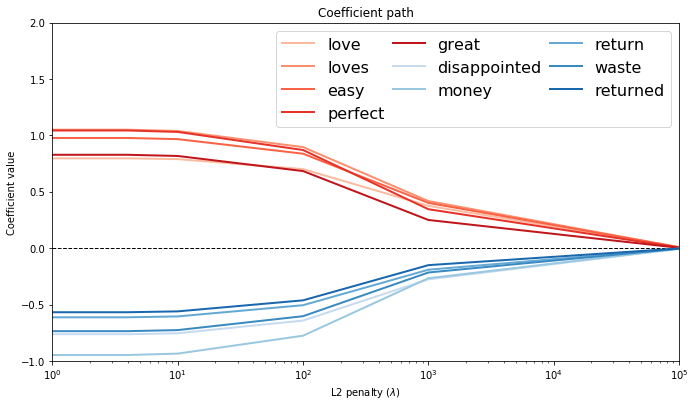

In [128]:
make_coefficient_plot(coef_df, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Answer**: True

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

**Answer**: False

## Measuring accuracy

**15**. Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [147]:
def cal_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    y_hat = np.array([+1 if s > 0 else -1 for s in scores])
    
    num_correct = (y_hat == sentiment).sum()
    accuracy = num_correct / len(y_hat)
    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [148]:
train_accuracy = {}
train_accuracy[0] = cal_accuracy(feature_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4] = cal_accuracy(feature_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10] = cal_accuracy(feature_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = cal_accuracy(feature_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = cal_accuracy(feature_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = cal_accuracy(feature_train, sentiment_train, coefficients_1e5_penalty)

valid_accuracy = {}
valid_accuracy[0] = cal_accuracy(feature_valid, sentiment_valid, coefficients_0_penalty)
valid_accuracy[4] = cal_accuracy(feature_valid, sentiment_valid, coefficients_4_penalty)
valid_accuracy[10] = cal_accuracy(feature_valid, sentiment_valid, coefficients_10_penalty)
valid_accuracy[1e2] = cal_accuracy(feature_valid, sentiment_valid, coefficients_1e2_penalty)
valid_accuracy[1e3] = cal_accuracy(feature_valid, sentiment_valid, coefficients_1e3_penalty)
valid_accuracy[1e5] = cal_accuracy(feature_valid, sentiment_valid, coefficients_1e5_penalty)

In [149]:
train_accuracy

{0: 0.7851561577866434,
 4: 0.7851089445480512,
 10: 0.7849909114515711,
 100.0: 0.7839758268218409,
 1000.0: 0.7758551497839994,
 100000.0: 0.6803663747314747}

In [151]:
# Build a simple report
for key in sorted(valid_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], valid_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.7851561577866434, validation_accuracy = 0.781439641490057
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7851089445480512, validation_accuracy = 0.7815330034543927
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7849909114515711, validation_accuracy = 0.7817197273830642
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7839758268218409, validation_accuracy = 0.781066193632714
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7758551497839994, validation_accuracy = 0.7713565493417982
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6803663747314747, validation_accuracy = 0.667818130893474
-----------------------------

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

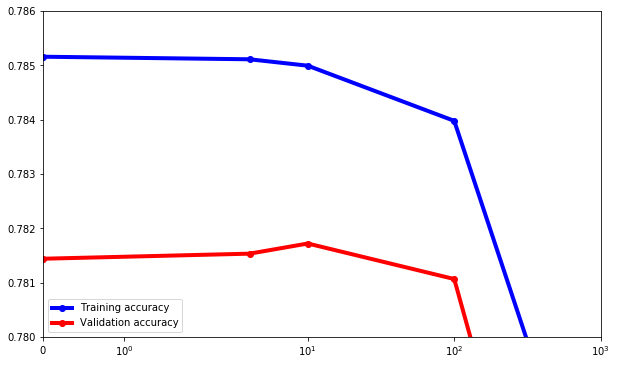

In [153]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(valid_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

**Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?  
**Answer**: L2 = 0

**Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?  
**Answer**: L2 = 10

**Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?  
**Answer**: not really.